#  Supervised Learning Assignment

####  S. Parker 2016

This notebook will examine the phishing dataset with decision trees.  It will look at the effectiveness of the decision trees relative to:

*  Levels in the decision tree
*  Number of training samples
*  Bias vs variance calculations
*  Performance metrics (memory used, time to fit, time to predict)

Also explored will be the effect of pre-pruning the data set and how this affects performance.

In [1]:
from sklearn import tree
from sklearn import ensemble
from sklearn import svm
from sklearn import neighbors
from sklearn.externals.six import StringIO  
import pandas as pd
import pydotplus
import numpy as np
import os, sys
import timeit
from IPython.display import display, HTML
from IPython.display import Image 
import matplotlib.pyplot as plt
%matplotlib inline
import arff

####  Control variables for simulation

In [2]:
training_test_split = .65

####  Helper function to allow us to get the size of the learning model

In [3]:
import sys
from numbers import Number
from collections import Set, Mapping, deque

try: # Python 2
    zero_depth_bases = (basestring, Number, xrange, bytearray)
    iteritems = 'iteritems'
except NameError: # Python 3
    zero_depth_bases = (str, bytes, Number, range, bytearray)
    iteritems = 'items'

def getsize(obj_0):
    """Recursively iterate to sum size of object & members."""
    def inner(obj, _seen_ids = set()):
        obj_id = id(obj)
        if obj_id in _seen_ids:
            return 0
        _seen_ids.add(obj_id)
        size = sys.getsizeof(obj)
        if isinstance(obj, zero_depth_bases):
            pass # bypass remaining control flow and return
        elif isinstance(obj, (tuple, list, Set, deque)):
            size += sum(inner(i) for i in obj)
        elif isinstance(obj, Mapping) or hasattr(obj, iteritems):
            size += sum(inner(k) + inner(v) for k, v in getattr(obj, iteritems)())
        # Check for custom object instances - may subclass above too
        if hasattr(obj, '__dict__'):
            size += inner(vars(obj))
        if hasattr(obj, '__slots__'): # can have __slots__ with __dict__
            size += sum(inner(getattr(obj, s)) for s in obj.__slots__ if hasattr(obj, s))
        return size
    return inner(obj_0)

##  Load and prepare training set #1

For this assignment I choose the following two data sets:
    
*  Phishing data set - looks at various attributes of a website address and compute whether the site if a phishing site or not

In [4]:
#  Load ARFF file
dataset_1_name = "Phishing"

arff_all = arff.load(open('datasets/phishing/Training Dataset.arff.txt'), 'rb')

#  Put data into dataframe
df_1_all = pd.DataFrame(arff_all["data"], columns=pd.DataFrame(arff_all["attributes"])[0])

#  Split into training and testing sets
split_ratio = .65
split_point = int(len(df_1_all) * split_ratio)

df_training = df_1_all[0:split_point]
df_testing  = df_1_all[split_point:]

In [5]:
df_1_all.head()

0  having_IP_Address  URL_Length  Shortining_Service  having_At_Symbol  \
0                  0           0                   0                 0   
1                  1           0                   0                 0   
2                  1           1                   0                 0   
3                  1           1                   0                 0   
4                  1           1                   1                 0   

0  double_slash_redirecting  Prefix_Suffix  having_Sub_Domain  SSLfinal_State  \
0                         0              0                  0               0   
1                         1              0                  1               1   
2                         1              0                  0               0   
3                         1              0                  0               0   
4                         1              0                  2               1   

0  Domain_registeration_length  Favicon   ...    popUpWidnow  Iframe  \
0                            0        0   ...              0       0   
1                            0        0   ...              0       0   
2                            0        0   ...              0       0   
3                            1        0   ...              0       0   
4                            0        0   ...              1       0   

0  age_of_domain  DNSRecord  web_traffic  Page_Rank  Google_Index  \
0              0          0            0          0             0   
1              0          0            1          0             0   
2              1          0            2          0             0   
3              0          0            2          0             0   
4              0          0            1          0             0   

0  Links_pointing_to_page  Statistical_report  Result  
0                       0                   0       0  
1                       0                   1       0  
2                       1                   0       0  
3                       2                   1       0  
4                       0                   1       1  

[5 rows x 31 columns]

##  Vary Decision Tree Depth to see effect on training and testing sets

In [6]:
clf = tree.DecisionTreeClassifier()

In [7]:
clf.fit(df_training.values[:,0:-1], df_training.values[:,-1])

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')

In [8]:
dot_data = StringIO()  
tree.export_graphviz(clf, out_file=dot_data,  
                     feature_names=df_training.columns.values,  
                     class_names=["False", "True"],  
                     filled=True, rounded=True,  
                     special_characters=True)  
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png()) 

####  Feature Importance.  For this part of the study, we will look at different features at look at their importance relative to the overall decision tree.

In [9]:
df_importance = pd.DataFrame()
df_importance["attribute"] = pd.DataFrame(arff_all["attributes"])[0][0:-1]
df_importance["importance"] = clf.feature_importances_
display(df_importance.sort_values(by="importance", ascending=0))

attribute  importance
13                URL_of_Anchor    0.536695
7                SSLfinal_State    0.193211
25                  web_traffic    0.057709
5                 Prefix_Suffix    0.030631
14                Links_in_tags    0.030550
6             having_Sub_Domain    0.021918
28       Links_pointing_to_page    0.016334
23                age_of_domain    0.015293
15                          SFH    0.012953
24                    DNSRecord    0.012021
12                  Request_URL    0.008651
26                    Page_Rank    0.007745
8   Domain_registeration_length    0.007455
19                 on_mouseover    0.005981
0             having_IP_Address    0.005790
11                  HTTPS_token    0.005337
27                 Google_Index    0.004686
1                    URL_Length    0.004608
16          Submitting_to_email    0.003547
2            Shortining_Service    0.003247
21                  popUpWidnow    0.003075
9                       Favicon    0.002740
18                     Redirect    0.002633
20                   RightClick    0.002074
3              having_At_Symbol    0.001598
17                 Abnormal_URL    0.001486
29           Statistical_report    0.001345
22                       Iframe    0.000542
4      double_slash_redirecting    0.000145
10                         port    0.000000

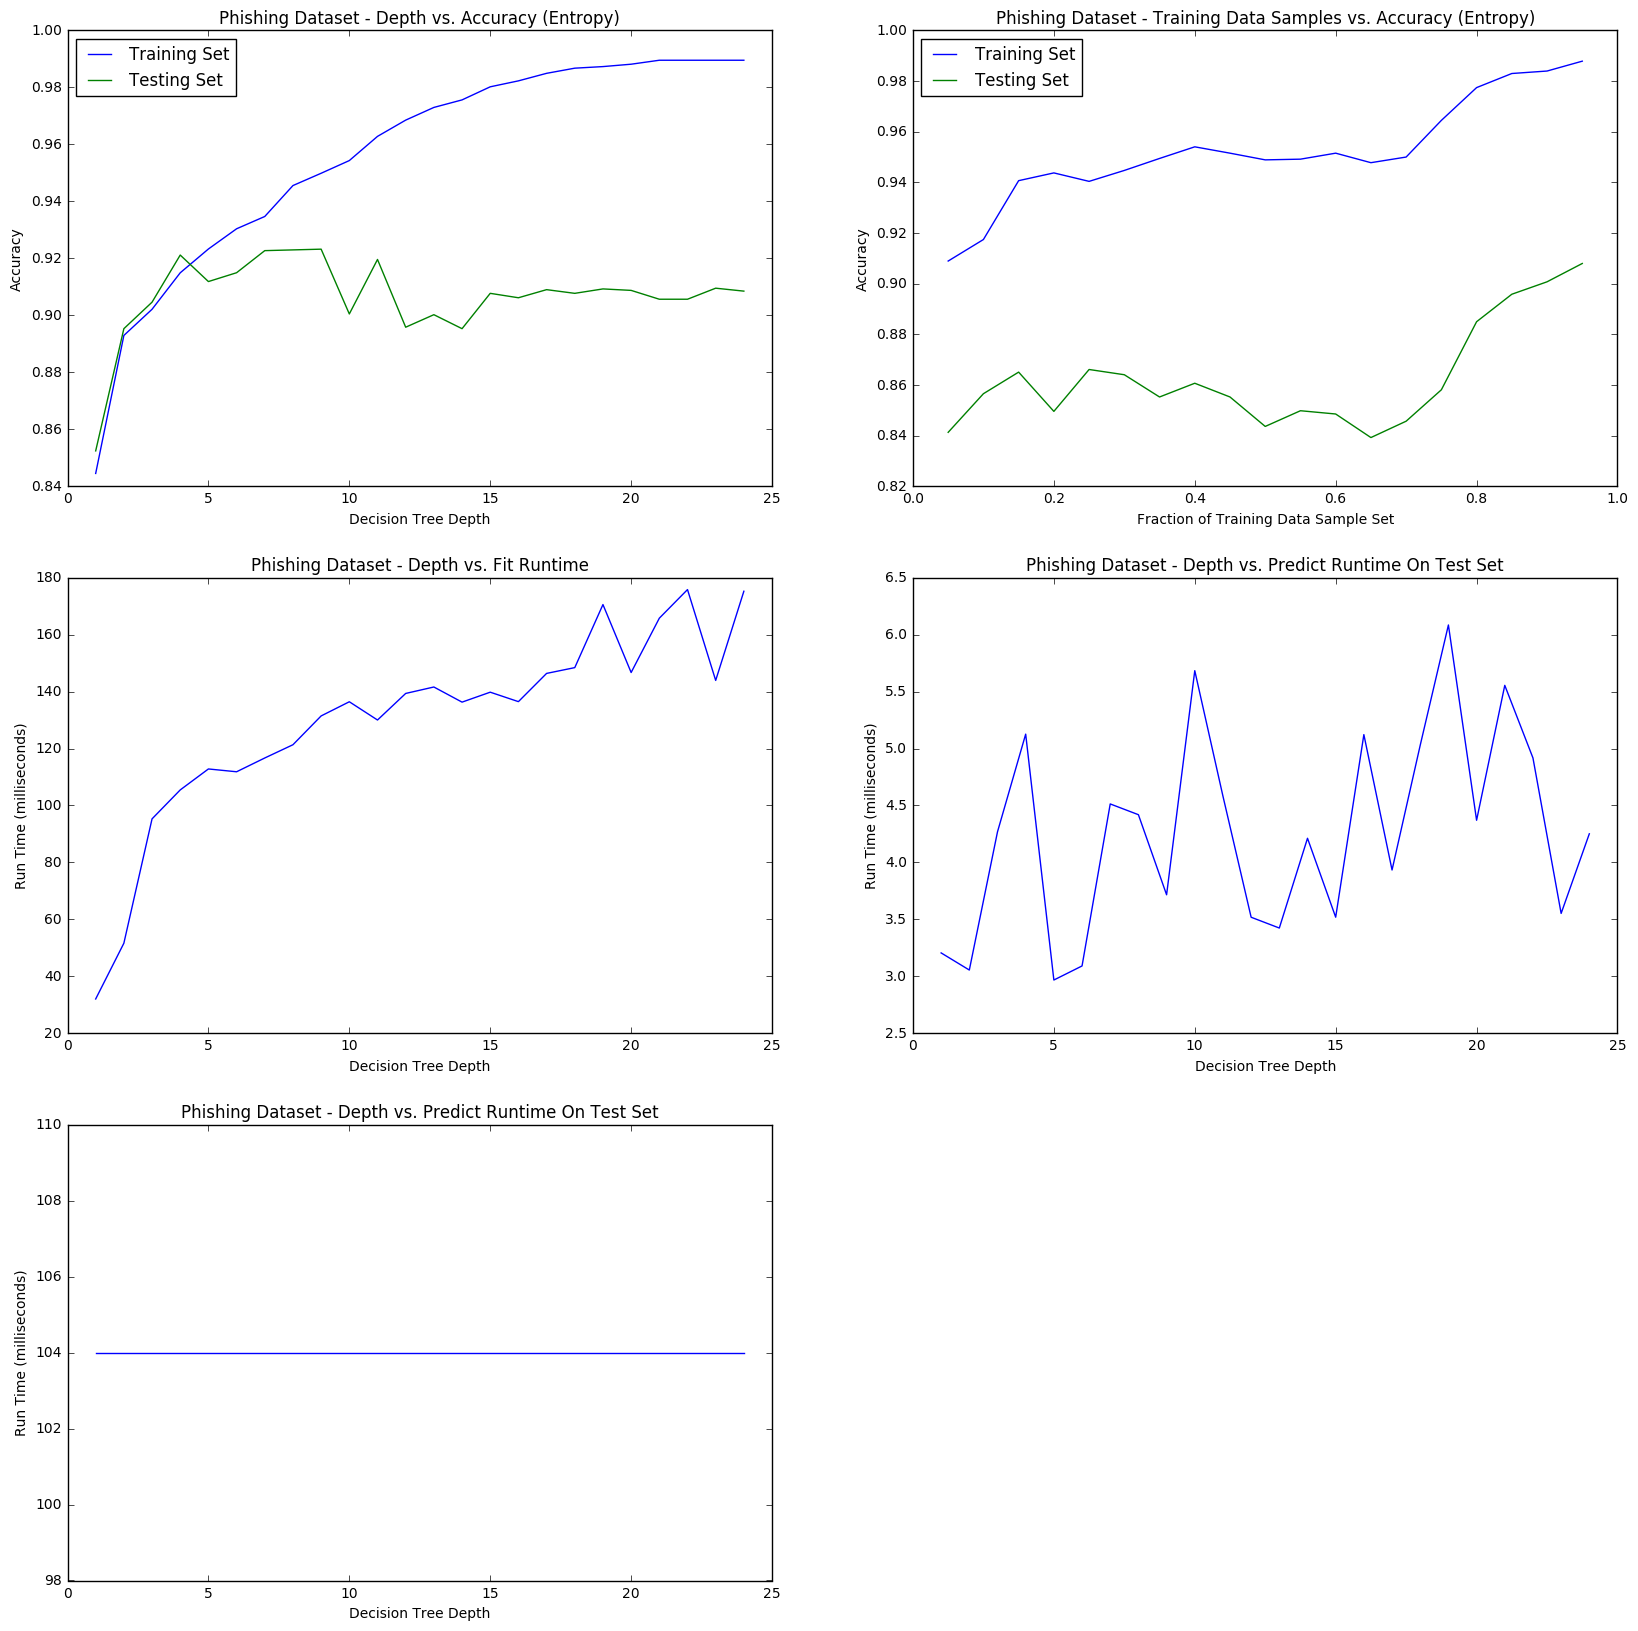

In [10]:
training_accuracy = []
testing_accuracy = []
fit_run_time = []
predict_run_time= []
memory_usage = []

depth_range = range(1,25)

for depth in depth_range:
    clf = tree.DecisionTreeClassifier(criterion="entropy", max_depth=depth)
    fit_run_time.append(timeit.timeit("clf.fit(df_training.values[:,0:-2], df_training.values[:,-1])", 
                    "from __main__ import clf, df_training",
                     number = 10))
    
    clf = tree.DecisionTreeClassifier(criterion="entropy", max_depth=depth)
    clf.fit(df_training.values[:,0:-2], df_training.values[:,-1])
    memory_usage.append(getsize(clf.tree_))
    
    training_accuracy.append(clf.score(df_training.values[:,0:-2], df_training.values[:,-1]))
    testing_accuracy.append(clf.score(df_testing.values[:,0:-2], df_testing.values[:,-1]))
    
    predict_run_time.append(timeit.timeit("clf.score(df_testing.values[:,0:-2], df_testing.values[:,-1])",
                                          "from __main__ import clf, df_testing",
                                          number=5))
    
fig = plt.figure(figsize=(20,20))    
    
plt.subplot(321)
plt.plot(depth_range, training_accuracy)
plt.plot(depth_range, testing_accuracy)
plt.title("Phishing Dataset - Depth vs. Accuracy (Entropy)")
plt.xlabel("Decision Tree Depth")
plt.ylabel("Accuracy")
plt.legend(["Training Set", "Testing Set"], loc=2)

plt.subplot(323)
plt.title("Phishing Dataset - Depth vs. Fit Runtime")
plt.plot(depth_range, np.array(fit_run_time) * 1000)
plt.ylabel("Run Time (milliseconds)")
plt.xlabel("Decision Tree Depth")

plt.subplot(324)
plt.title("Phishing Dataset - Depth vs. Predict Runtime On Test Set")
plt.plot(depth_range, np.array(predict_run_time) * 1000)
plt.ylabel("Run Time (milliseconds)")
plt.xlabel("Decision Tree Depth")

plt.subplot(325)
plt.title("Phishing Dataset - Depth vs. Predict Runtime On Test Set")
plt.plot(depth_range, memory_usage)
plt.ylabel("Run Time (milliseconds)")
plt.xlabel("Decision Tree Depth")

training_accuracy = []
testing_accuracy = []

percent_of_training_data = np.arange(.05,1.0,.05)

for percent in percent_of_training_data:
    clf = tree.DecisionTreeClassifier(criterion="entropy")
#    clf = ensemble.AdaBoostClassifier()
#    clf = svm.SVC()
#    clf = neighbors.NearestNeighbors()
    clf.fit(df_training.values[0:int(percent * len(df_training)),0:-2], \
            df_training.values[0:int(percent * len(df_training)),-1])
    
    training_accuracy.append(clf.score(df_training.values[:,0:-2], df_training.values[:,-1]))
    testing_accuracy.append(clf.score(df_testing.values[:,0:-2], df_testing.values[:,-1]))
    
    predict_run_time.append(timeit.timeit("clf.score(df_testing.values[:,0:-2], df_testing.values[:,-1])",
                                          "from __main__ import clf, df_testing",
                                          number=5))

plt.subplot(322)
plt.plot(percent_of_training_data, training_accuracy)
plt.plot(percent_of_training_data, testing_accuracy)
plt.title("Phishing Dataset - Training Data Samples vs. Accuracy (Entropy)")
plt.xlabel("Fraction of Training Data Sample Set")
plt.ylabel("Accuracy")
plt.legend(["Training Set", "Testing Set"], loc=2)

Now let's look at an example with some pruning.

In [11]:
getsize(clf.tree_)

104

In [12]:
df_importance[df_importance["importance"] < .01]["attribute"].values

array(['having_IP_Address', 'URL_Length', 'Shortining_Service',
       'having_At_Symbol', 'double_slash_redirecting',
       'Domain_registeration_length', 'Favicon', 'port', 'HTTPS_token',
       'Request_URL', 'Submitting_to_email', 'Abnormal_URL', 'Redirect',
       'on_mouseover', 'RightClick', 'popUpWidnow', 'Iframe', 'Page_Rank',
       'Google_Index', 'Statistical_report'], dtype=object)

In [17]:
len(df_importance[df_importance["importance"] < .02]["attribute"].values)

24

In [13]:
df_training = df_training.drop(df_importance[df_importance["importance"] < .02]["attribute"].values, 1)
df_testing  = df_testing.drop(df_importance[df_importance["importance"] < .02]["attribute"].values, 1)

In [14]:
df_training.describe()

0      Prefix_Suffix  having_Sub_Domain  SSLfinal_State  URL_of_Anchor  \
count    7185.000000        7185.000000     7185.000000    7185.000000   
mean        0.133333           0.954767        0.778566       0.928184   
std         0.339958           0.797607        0.613587       0.715419   
min         0.000000           0.000000        0.000000       0.000000   
25%         0.000000           0.000000        0.000000       0.000000   
50%         0.000000           1.000000        1.000000       1.000000   
75%         0.000000           2.000000        1.000000       1.000000   
max         1.000000           2.000000        2.000000       2.000000   

0      Links_in_tags  web_traffic       Result  
count    7185.000000  7185.000000  7185.000000  
mean        1.173556     1.290745     0.556576  
std         0.786560     0.837561     0.496823  
min         0.000000     0.000000     0.000000  
25%         1.000000     1.000000     0.000000  
50%         1.000000     2.000000     1.000000  
75%         2.000000     2.000000     1.000000  
max         2.000000     2.000000     1.000000

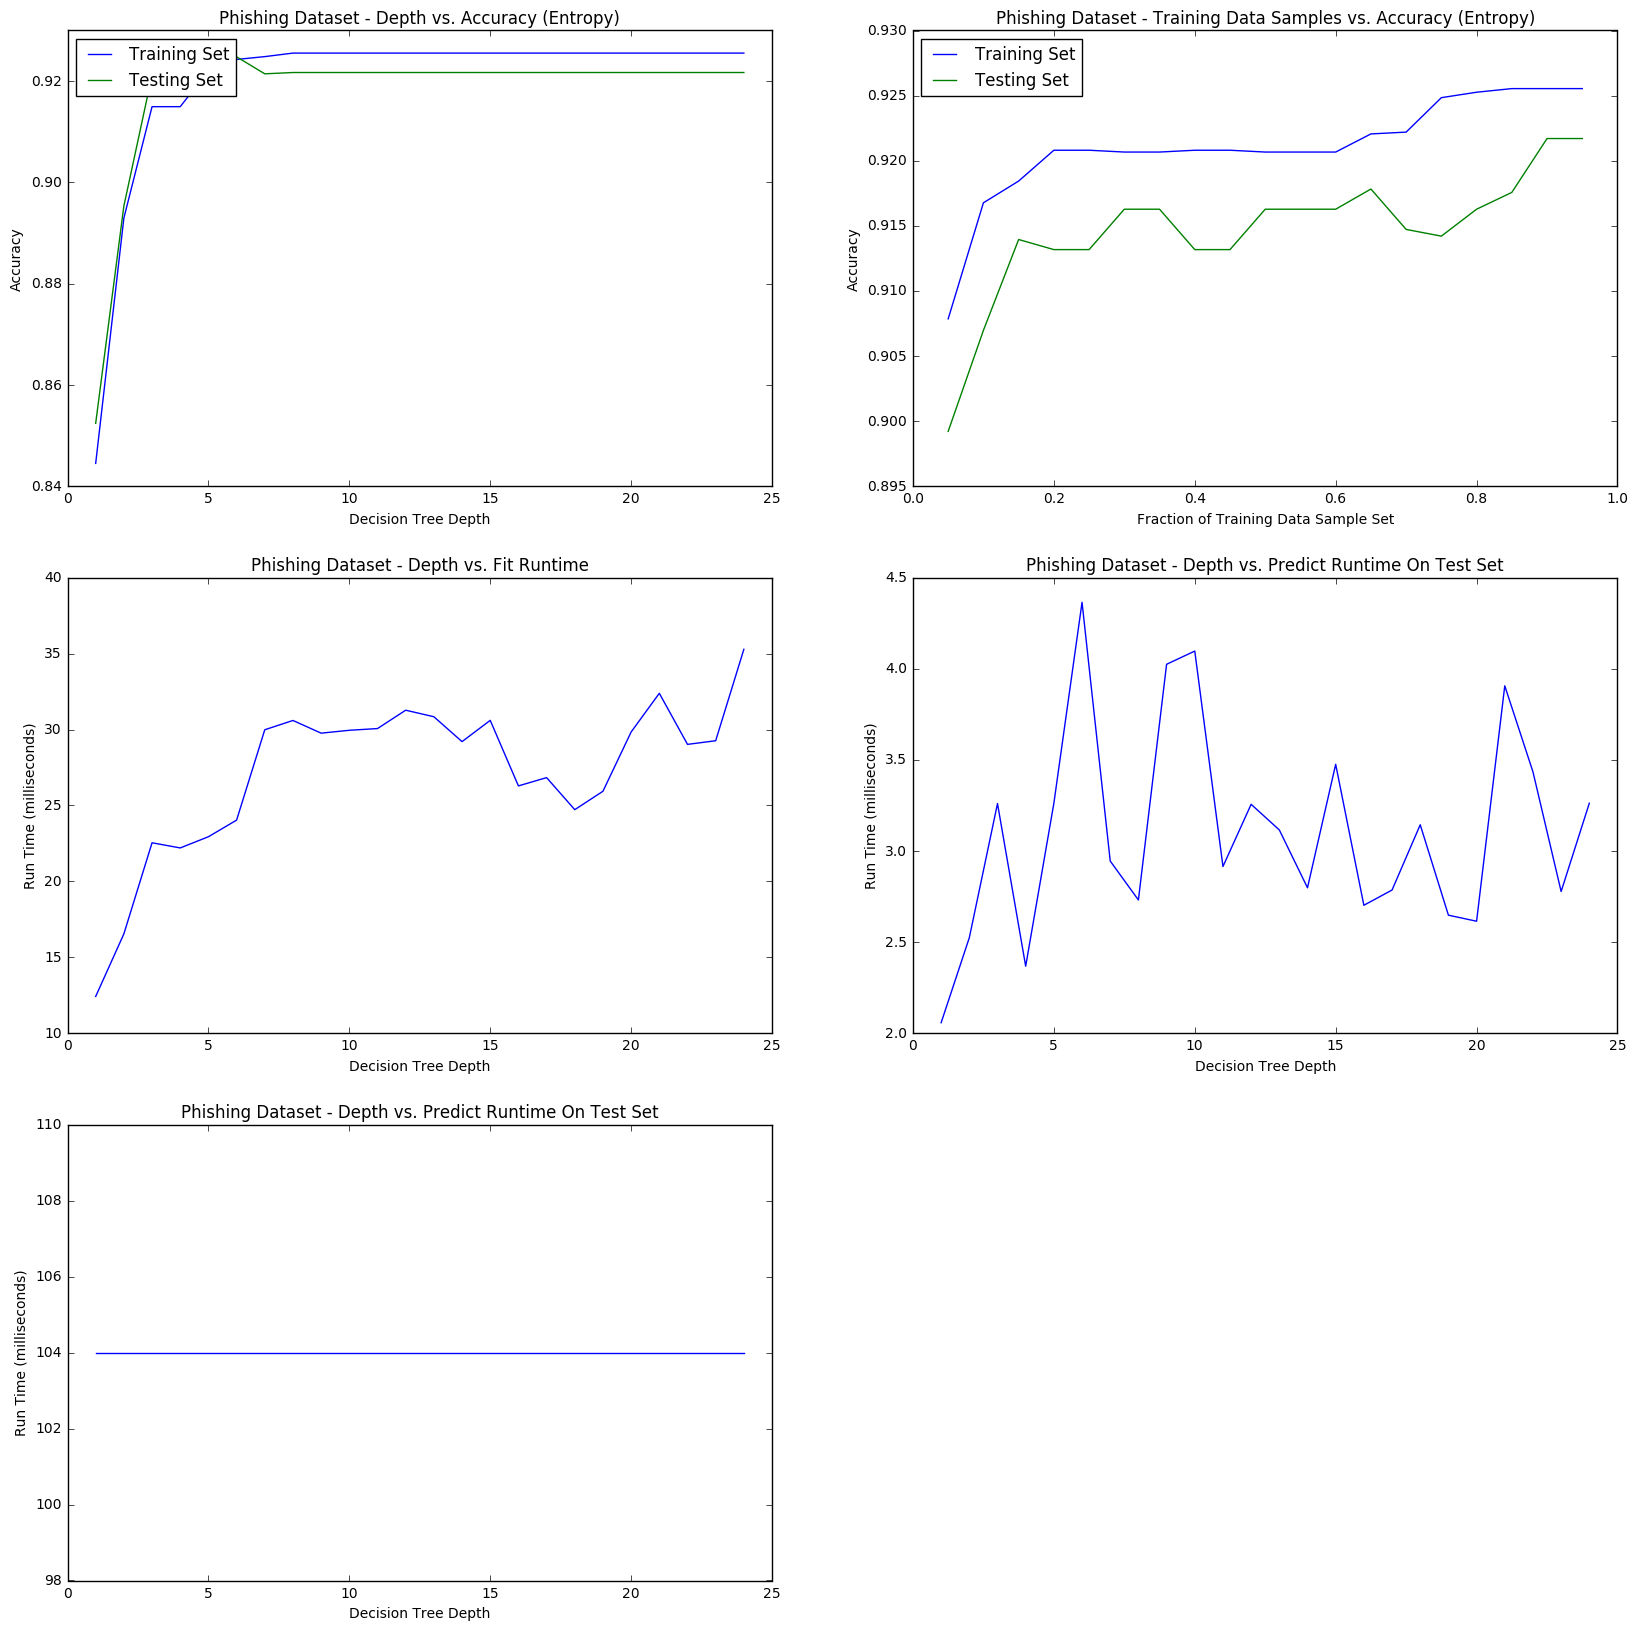

In [15]:
training_accuracy = []
testing_accuracy = []
fit_run_time = []
predict_run_time= []
memory_usage = []

depth_range = range(1,25)

for depth in depth_range:
    clf = tree.DecisionTreeClassifier(criterion="entropy", max_depth=depth)
    fit_run_time.append(timeit.timeit("clf.fit(df_training.values[:,0:-2], df_training.values[:,-1])", 
                    "from __main__ import clf, df_training",
                     number = 10))
    
    clf = tree.DecisionTreeClassifier(criterion="entropy", max_depth=depth)
    clf.fit(df_training.values[:,0:-2], df_training.values[:,-1])
    memory_usage.append(getsize(clf.tree_))
    
    training_accuracy.append(clf.score(df_training.values[:,0:-2], df_training.values[:,-1]))
    testing_accuracy.append(clf.score(df_testing.values[:,0:-2], df_testing.values[:,-1]))
    
    predict_run_time.append(timeit.timeit("clf.score(df_testing.values[:,0:-2], df_testing.values[:,-1])",
                                          "from __main__ import clf, df_testing",
                                          number=5))
    
fig = plt.figure(figsize=(20,20))    
    
plt.subplot(321)
plt.plot(depth_range, training_accuracy)
plt.plot(depth_range, testing_accuracy)
plt.title("Phishing Dataset - Depth vs. Accuracy (Entropy)")
plt.xlabel("Decision Tree Depth")
plt.ylabel("Accuracy")
plt.legend(["Training Set", "Testing Set"], loc=2)

plt.subplot(323)
plt.title("Phishing Dataset - Depth vs. Fit Runtime")
plt.plot(depth_range, np.array(fit_run_time) * 1000)
plt.ylabel("Run Time (milliseconds)")
plt.xlabel("Decision Tree Depth")

plt.subplot(324)
plt.title("Phishing Dataset - Depth vs. Predict Runtime On Test Set")
plt.plot(depth_range, np.array(predict_run_time) * 1000)
plt.ylabel("Run Time (milliseconds)")
plt.xlabel("Decision Tree Depth")

plt.subplot(325)
plt.title("Phishing Dataset - Depth vs. Predict Runtime On Test Set")
plt.plot(depth_range, memory_usage)
plt.ylabel("Run Time (milliseconds)")
plt.xlabel("Decision Tree Depth")

training_accuracy = []
testing_accuracy = []

percent_of_training_data = np.arange(.05,1.0,.05)

for percent in percent_of_training_data:
    clf = tree.DecisionTreeClassifier(criterion="entropy")
#    clf = ensemble.AdaBoostClassifier()
#    clf = svm.SVC()
#    clf = neighbors.NearestNeighbors()
    clf.fit(df_training.values[0:int(percent * len(df_training)),0:-2], \
            df_training.values[0:int(percent * len(df_training)),-1])
    
    training_accuracy.append(clf.score(df_training.values[:,0:-2], df_training.values[:,-1]))
    testing_accuracy.append(clf.score(df_testing.values[:,0:-2], df_testing.values[:,-1]))
    
    predict_run_time.append(timeit.timeit("clf.score(df_testing.values[:,0:-2], df_testing.values[:,-1])",
                                          "from __main__ import clf, df_testing",
                                          number=5))

plt.subplot(322)
plt.plot(percent_of_training_data, training_accuracy)
plt.plot(percent_of_training_data, testing_accuracy)
plt.title("Phishing Dataset - Training Data Samples vs. Accuracy (Entropy)")
plt.xlabel("Fraction of Training Data Sample Set")
plt.ylabel("Accuracy")
plt.legend(["Training Set", "Testing Set"], loc=2)